In [1]:
PATH='/home/kirana/Documents/phd/exp3_autoencoder'
DATAPATH='/home/kirana/Documents/final_dissertation_final/experiments/datasets/ml-1m'

In [2]:
import pandas as pd
import numpy as np
import os
import datetime
import sklearn
import torch
import pickle
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
from torch import nn

In [3]:
[df, df_train,df_valid,df,df_ratings,idx_to_user,\
             idx_to_movie,movie_to_idx,user_to_idx]=pickle.load(open(f'{DATAPATH}/reads.pkl','rb'))

## Dataset and DataLoader

In [4]:
df_train.shape,df_valid.shape

((6041, 3707), (6041, 3707))

In [5]:
df_train[1]

<1x3707 sparse matrix of type '<class 'numpy.int64'>'
	with 95 stored elements in Compressed Sparse Row format>

In [6]:
df_train[1].todense().shape

(1, 3707)

In [7]:
df_train[1].todense().getA1().shape

(3707,)

In [8]:
class autoencdata (Dataset):
    def __init__(self,dfX,dfXv):
        self.dfX,self.dfXv=dfX,dfXv
        
    def __len__ (self):
        return self.dfX.shape[0]
    
    def __getitem__ (self, idx):
        return torch.FloatTensor(self.dfX[idx].todense().getA1()),torch.FloatTensor(self.dfXv[idx].todense().getA1())

In [9]:
dstrain=autoencdata(df_train, df_valid)
#dsvalid=autoencdata(df_valid)

In [10]:
bs=8

In [11]:
# Create a DataLoader object
dltrain=DataLoader(dstrain,batch_size=bs,shuffle=False)
#dlvalid=DataLoader(dsvalid,batch_size=bs,shuffle=False) 

In [12]:
df_train.min(),df_train.max()

(0, 5)

In [13]:
df_train.shape

(6041, 3707)

In [14]:
len(dltrain)

756

In [15]:
df_train.shape

(6041, 3707)

In [18]:
# 6041 users

## Create the Model Architecture for the Encoder

In [16]:
def hidden_layer(x,y,dropout,activation=nn.Sigmoid()):
    return nn.Sequential(
        nn.Linear(x, y),
        activation,
        nn.Dropout(p=dropout)
        )   

In [17]:
class autoencoder (nn.Module):    
    def __init__(self,n_inp=9724,hidden=[50,10],dropouts=[0,0,0],rating_range=[0.5,5]):
        super().__init__()
        self.n_inp,self.hidden,self.dropouts,self.rating_range=n_inp,hidden,dropouts,rating_range
        encoder=[hidden_layer(n_inp if i==0 else hidden[i-1],hidden[i],dropouts[i],\
                              nn.Sigmoid() if i<len(hidden)-1 else nn.Tanh()) for i in range(len(hidden))]
        self.encoder=nn.Sequential(*encoder)
        hidden=hidden[::-1]
        num_steps=len(hidden)-1
        dropouts=dropouts[num_steps:]
        decoder=[hidden_layer(hidden[i],hidden[i+1] if i<len(hidden)-1 else n_inp,dropouts[i]) for i in range(len(hidden)-1)]
        self.decoder=nn.Sequential(*decoder)
        self.fc=nn.Linear(hidden[-1],n_inp)
        self.initialize()
        self.criterion=nn.MSELoss()
    
    def initialize(self):
        for x in self.encoder:
            nn.init.kaiming_normal_(x[0].weight.data)
        for x in self.decoder:
            nn.init.kaiming_normal_(x[0].weight.data)

    def forward (self,Xb):
        encoded=self.encoder(Xb)
        decoded=self.decoder(encoded)
        out=self.fc(decoded)
        outv=out.clone()
        out[Xb==0]=0
        loss=self.criterion(out,Xb)
        return outv,loss, out

In [19]:
n_final_user=10 # 3 for IMDB

In [20]:
autoenc=autoencoder(df_train.shape[1],[n_final_user*4,n_final_user],[0,0,0])

In [21]:
autoenc

autoencoder(
  (encoder): Sequential(
    (0): Sequential(
      (0): Linear(in_features=3707, out_features=40, bias=True)
      (1): Sigmoid()
      (2): Dropout(p=0)
    )
    (1): Sequential(
      (0): Linear(in_features=40, out_features=10, bias=True)
      (1): Tanh()
      (2): Dropout(p=0)
    )
  )
  (decoder): Sequential(
    (0): Sequential(
      (0): Linear(in_features=10, out_features=40, bias=True)
      (1): Sigmoid()
      (2): Dropout(p=0)
    )
  )
  (fc): Linear(in_features=40, out_features=3707, bias=True)
  (criterion): MSELoss()
)

In [22]:
for Xb,Xb_v in dltrain:
    print (Xb)
    break

tensor([[4., 0., 0.,  ..., 0., 0., 0.],
        [0., 2., 0.,  ..., 0., 0., 0.],
        [0., 0., 3.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 3.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]])


In [23]:
Xb.size()

torch.Size([8, 3707])

In [24]:
Xb.squeeze(0)

tensor([[4., 0., 0.,  ..., 0., 0., 0.],
        [0., 2., 0.,  ..., 0., 0., 0.],
        [0., 0., 3.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 3.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]])

In [25]:
preds,loss,_=autoenc.forward(Xb)

In [26]:
loss.backward()

In [27]:
preds.size()

torch.Size([8, 3707])

In [28]:
nn.MSELoss

torch.nn.modules.loss.MSELoss

In [29]:
device="cuda:1"

In [30]:
wd=1e-4
#wd=1e-1

In [31]:
optimizer=torch.optim.Adam(autoenc.parameters(),lr=5e-3,betas=(0.9,0.999), weight_decay=wd)
#optimizer=torch.optim.SGD(model_sentiment.parameters(),lr=1e-2,momentum=0.9, weight_decay=wd)
metric_fn=None

In [32]:
len(dltrain)

756

In [33]:
import matplotlib.pyplot as plt

In [34]:
dltrain.batch_size

8

In [35]:
class Learner():
    def __init__(self,model,optimizer,metric_fn,device,bptt=12,print_every=5,clip_val=None,\
                 cycle_mult=0,lr_decay=0.7,wd_mult=6,start_lr=2e-2, end_lr=5e-4):
        self.model,self.optimizer,self.metric_fn,self.device,self.print_every,self.bptt,self.losses,self.clip_val=\
            model,optimizer,metric_fn,device,print_every,bptt,[],clip_val
        self.n_epochs=1
        self.cycle_mult,self.lr_decay=cycle_mult,lr_decay
        self.wd_mult=wd_mult
        for param_group in self.optimizer.param_groups:
            self.start_lr=param_group['lr']
            self.start_wd=param_group['weight_decay']
        self.wd=self.start_wd
        self.lr=self.start_lr
        self.end_lr=end_lr
        self.n_epoch=0
        self.lrs=[1e-2,5e-3,1e-4,5e-4]
        self.preds,self.preds_valid,self.trainY,self.actual=[],[],[],[]
        self.ratio=self.end_lr/self.start_lr
        self.num_steps=self.cycle_mult
        self.reset_cycle=self.cycle_mult
        
    def fit (self,Xb,Xb_v,mode_train=True):
        if mode_train:
            self.model.train()
        else:
            self.model.eval()
        
        #import pdb
        #pdb.set_trace()
        preds,loss,preds_train=self.model(Xb)
        # denominator is the average of the error with non-zero ratings

        mean_corrector = Xb.size(0)*Xb.size(1)/(torch.sum(Xb > 0).float() + 1e-10)
        mean_corrector_v = Xb_v.size(0)*Xb_v.size(1)/(torch.sum(Xb_v > 0).float() + 1e-10)

        with torch.no_grad():
            
            preds[Xb_v==0]=0
            loss_v=self.model.criterion(preds,Xb_v)
            
            if self.metric_fn is not None:
                acc=self.metric_fn(preds,Yb.view(-1),self.device)
                acc=acc.item()

                if 1==0:
                    if mode_train:
                        self.trainY.append(Yb.view(-1))
                        self.preds.append(preds.data)
                    else:
                        self.actual.append(Yb.view(-1))
                        self.preds_valid.append(preds.data)
            else:
                acc=0
                acc_v=0
            del preds
        
        if mode_train:
            if 1==0:
                lr =self.lrs[torch.randint(0,4,(1,))]
                for param_group in self.optimizer.param_groups:
                    param_group['lr']=lr
            
            self.optimizer.zero_grad()
            loss.backward()
            self.optimizer.step()
        myloss=torch.sqrt(loss.item()*mean_corrector)
        myloss_v=torch.sqrt(loss_v.item()*mean_corrector_v)
        del loss
        
        if self.clip_val is not None:
            torch.nn.utils.clip_grad_norm_(self.model.parameters(), self.clip_val)
        
        return myloss, acc,myloss_v,acc_v
    
    def lr_find (self,start_lr,end_lr,iterator,n_batch):
        losses,lrs=[],[]
        ratio=end_lr/start_lr
        num_steps=n_batch
        lr=start_lr
        for i in range(num_steps):            
            lr=lr*(end_lr/start_lr)**(1/num_steps)
            lrs.append(lr)
        self.lrs=lrs
        self.run_epoch(iterator,mode_train=True,lrs=lrs)
    
    def run_epoch(self,iterator,mode_train,lrs=None):
        epoch_loss,epoch_acc,i,k=0,0,0,0
        epoch_loss_v,epoch_acc_v=0,0

        for Xb,Xb_v in iterator:
            Xb=Xb.to(self.device)
            Xb_v=Xb_v.to(self.device)
            #Xb=Xb.squeeze(0)
            if lrs is not None:
                lr=lrs[k]
                for param_group in self.optimizer.param_groups:
                    param_group['lr']=lr 
            

            loss,acc,loss_v,acc_v=self.fit(Xb,Xb_v,mode_train)
            
            if lrs is not None:
                self.losses.append(loss)
            
            epoch_loss+=loss
            epoch_acc+=acc
            epoch_loss_v+=loss_v
            epoch_acc_v+=acc_v
            
            k=k+1
            if k%self.print_every == 0:
                if k:
                    print (f'Batch:{k} {epoch_loss/(k)} {epoch_loss_v/(k)} ')  
                    torch.cuda.empty_cache()
        epoch_loss=epoch_loss/len(iterator)
        epoch_acc=epoch_acc/len(iterator)
        epoch_loss_v=epoch_loss_v/len(iterator)
        epoch_acc_v=epoch_acc_v/len(iterator)
            
        return epoch_loss,epoch_acc,epoch_loss_v,epoch_acc_v
    
    def plot_lrs(self, n_roll=1,ylim=None,xlim=None):
        import seaborn as sns
        ax=sns.lineplot(x=self.lrs,y=pd.Series(self.losses).rolling(n_roll).mean())
        ax.set_xscale('log')
        ax.set_ylabel('Loss')
        ax.set_xlabel('Learning Rate')
        if ylim is not None:
            plt.ylim(ylim)
        if xlim is not None:
            plt.xlim(xlim)

     
    def run_epochs(self,dltrain,dlvalid,n_epochs=1):
        
        
            
        
        for epoch in range(n_epochs):                

            loss,acc,lossv,accv=self.run_epoch(dltrain,True)
            print (f'Epoch:{epoch} Learning rate {self.lr} Weight Decay {self.wd} Train Loss:{loss}  Valid Loss:{lossv} ')
  
            if self.cycle_mult:
                if self.n_epoch==self.reset_cycle:
                    self.lr=self.start_lr
                    #self.wd=self.start_wd
                    self.reset_cycle*=self.cycle_mult
                    #reset_cycle=self.n_epoch+reset_cycle
                    self.n_epoch=0
                    self.ratio=self.end_lr/self.start_lr
                    self.num_steps=self.reset_cycle
                else:
                    #self.lr*=(self.lr_decay**self.n_epoch)  
                    #if self.n_epoch>1:
                    #    self.wd*=self.wd_mult
                    self.lr=self.lr*(self.end_lr/self.start_lr)**(1/self.num_steps)
                    self.n_epoch+=1
        

                
            for param_group in self.optimizer.param_groups:
                param_group['lr']=self.lr
                #param_group['weight_decay']=self.wd
          
     

In [36]:
autoenc

autoencoder(
  (encoder): Sequential(
    (0): Sequential(
      (0): Linear(in_features=3707, out_features=40, bias=True)
      (1): Sigmoid()
      (2): Dropout(p=0)
    )
    (1): Sequential(
      (0): Linear(in_features=40, out_features=10, bias=True)
      (1): Tanh()
      (2): Dropout(p=0)
    )
  )
  (decoder): Sequential(
    (0): Sequential(
      (0): Linear(in_features=10, out_features=40, bias=True)
      (1): Sigmoid()
      (2): Dropout(p=0)
    )
  )
  (fc): Linear(in_features=40, out_features=3707, bias=True)
  (criterion): MSELoss()
)

In [37]:
autoenc=autoencoder(df_train.shape[1],[n_final_user*4,n_final_user],[0.2,0.2,0]).to(device)
wd=1e-7
optimizer=torch.optim.Adam(autoenc.parameters(),lr=5e-3,betas=(0.9,0.999), weight_decay=wd)

In [38]:
learner=Learner(autoenc,optimizer,None,device,0,500,0.25,cycle_mult=0)

In [39]:
autoenc

autoencoder(
  (encoder): Sequential(
    (0): Sequential(
      (0): Linear(in_features=3707, out_features=40, bias=True)
      (1): Sigmoid()
      (2): Dropout(p=0.2)
    )
    (1): Sequential(
      (0): Linear(in_features=40, out_features=10, bias=True)
      (1): Tanh()
      (2): Dropout(p=0.2)
    )
  )
  (decoder): Sequential(
    (0): Sequential(
      (0): Linear(in_features=10, out_features=40, bias=True)
      (1): Sigmoid()
      (2): Dropout(p=0.2)
    )
  )
  (fc): Linear(in_features=40, out_features=3707, bias=True)
  (criterion): MSELoss()
)

In [40]:
len(dltrain),dltrain.batch_size

(756, 8)

In [41]:
learner.lr_find(1e-4,3e-1,dltrain,len(dltrain))

Batch:500 2.1489453315734863 2.145568370819092 


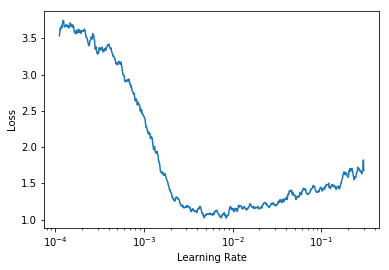

In [42]:
learner.plot_lrs(10)

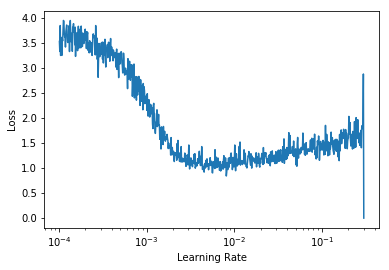

In [43]:
learner.plot_lrs(1)

In [44]:
del autoenc
torch.cuda.empty_cache()

In [45]:
autoenc=autoencoder(df_train.shape[1],[n_final_user*4,n_final_user],[0.2,0.2,0]).to(device)
wd=1e-7
optimizer=torch.optim.Adam(autoenc.parameters(),lr=1e-3,betas=(0.9,0.999), weight_decay=wd)
learner=Learner(autoenc,optimizer,None,device,0,1000,0.25,cycle_mult=0,start_lr=1e-1,end_lr=5e-2)

In [46]:
learner.run_epochs(dltrain,None,5)

Epoch:0 Learning rate 0.001 Weight Decay 1e-07 Train Loss:1.3733470439910889  Valid Loss:1.361444354057312 
Epoch:1 Learning rate 0.001 Weight Decay 1e-07 Train Loss:1.0656039714813232  Valid Loss:1.0572052001953125 
Epoch:2 Learning rate 0.001 Weight Decay 1e-07 Train Loss:1.0520453453063965  Valid Loss:1.0428134202957153 
Epoch:3 Learning rate 0.001 Weight Decay 1e-07 Train Loss:1.0470517873764038  Valid Loss:1.0405282974243164 
Epoch:4 Learning rate 0.001 Weight Decay 1e-07 Train Loss:1.0406324863433838  Valid Loss:1.033848762512207 


In [47]:
torch.save(autoenc,f=f'{DATAPATH}/inter/user_autoenc')
torch.save(learner,f=f'{DATAPATH}/inter/user_autoenc_learner')
torch.save(optimizer,f=f'{DATAPATH}/inter/user_autoenc_optimizer')
torch.save(autoenc.state_dict(),f'{DATAPATH}/inter/user_autoenc_state_dict')
torch.save(optimizer.state_dict(),f'{DATAPATH}/inter/user_autoenc_optimizer_state_dict')

/home/kirana/anaconda3/lib/python3.7/site-packages/torch/serialization.py:256: UserWarning: Couldn't retrieve source code for container of type autoencoder. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/home/kirana/anaconda3/lib/python3.7/site-packages/torch/serialization.py:256: UserWarning: Couldn't retrieve source code for container of type autoencoder. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


In [48]:
wd=1e-7
optimizer=torch.optim.Adam(autoenc.parameters(),lr=5e-3,betas=(0.9,0.999), weight_decay=wd)
learner=Learner(autoenc,optimizer,None,device,0,1000,0.25,cycle_mult=2,start_lr=1e-3,end_lr=1e-4)

In [49]:
learner.run_epochs(dltrain,None,15)

Epoch:0 Learning rate 0.005 Weight Decay 1e-07 Train Loss:1.067874789237976  Valid Loss:1.0604629516601562 
Epoch:1 Learning rate 0.0007071067811865475 Weight Decay 1e-07 Train Loss:1.0256401300430298  Valid Loss:1.0193865299224854 
Epoch:2 Learning rate 9.999999999999999e-05 Weight Decay 1e-07 Train Loss:1.0176974534988403  Valid Loss:1.0166035890579224 
Epoch:3 Learning rate 0.005 Weight Decay 1e-07 Train Loss:1.0530714988708496  Valid Loss:1.0457947254180908 
Epoch:4 Learning rate 0.001880301546543197 Weight Decay 1e-07 Train Loss:1.0224027633666992  Valid Loss:1.0183391571044922 
Epoch:5 Learning rate 0.0007071067811865476 Weight Decay 1e-07 Train Loss:1.0100343227386475  Valid Loss:1.005719780921936 
Epoch:6 Learning rate 0.0002659147948472495 Weight Decay 1e-07 Train Loss:1.004396677017212  Valid Loss:1.0029422044754028 
Epoch:7 Learning rate 0.00010000000000000003 Weight Decay 1e-07 Train Loss:1.003002405166626  Valid Loss:1.0013680458068848 
Epoch:8 Learning rate 0.005 Weight D

In [50]:
learner.run_epochs(dltrain,None,15)

Epoch:0 Learning rate 0.00016306894089533107 Weight Decay 1e-07 Train Loss:0.9856678247451782  Valid Loss:0.9848763942718506 
Epoch:1 Learning rate 0.00010000000000000007 Weight Decay 1e-07 Train Loss:0.9835518598556519  Valid Loss:0.9857105612754822 
Epoch:2 Learning rate 0.005 Weight Decay 1e-07 Train Loss:1.0321764945983887  Valid Loss:1.0261956453323364 
Epoch:3 Learning rate 0.003915474312000093 Weight Decay 1e-07 Train Loss:1.0163992643356323  Valid Loss:1.0137494802474976 
Epoch:4 Learning rate 0.0030661878175865195 Weight Decay 1e-07 Train Loss:1.0065451860427856  Valid Loss:1.0034610033035278 
Epoch:5 Learning rate 0.0024011159271055283 Weight Decay 1e-07 Train Loss:0.9978454113006592  Valid Loss:0.9954686760902405 
Epoch:6 Learning rate 0.0018803015465431964 Weight Decay 1e-07 Train Loss:0.9913275837898254  Valid Loss:0.9895416498184204 
Epoch:7 Learning rate 0.0014724544808607863 Weight Decay 1e-07 Train Loss:0.9878281950950623  Valid Loss:0.9891547560691833 
Epoch:8 Learnin

In [69]:
wd=1e-7
optimizer=torch.optim.Adam(autoenc.parameters(),lr=7e-3,betas=(0.9,0.999), weight_decay=wd)
learner=Learner(autoenc,optimizer,None,device,0,1000,0.25,cycle_mult=2,start_lr=1e-3,end_lr=1e-4)

In [70]:
learner.run_epochs(dltrain,None,15)

Epoch:0 Learning rate 0.007 Weight Decay 1e-07 Train Loss:1.014534592628479  Valid Loss:1.0099493265151978 
Epoch:1 Learning rate 0.0008366600265340755 Weight Decay 1e-07 Train Loss:0.9800724983215332  Valid Loss:0.98431396484375 
Epoch:2 Learning rate 9.999999999999999e-05 Weight Decay 1e-07 Train Loss:0.9691317677497864  Valid Loss:0.9748996496200562 
Epoch:3 Learning rate 0.007 Weight Decay 1e-07 Train Loss:1.019723653793335  Valid Loss:1.0162816047668457 
Epoch:4 Learning rate 0.002420045492493587 Weight Decay 1e-07 Train Loss:0.9862945079803467  Valid Loss:0.9842365384101868 
Epoch:5 Learning rate 0.0008366600265340755 Weight Decay 1e-07 Train Loss:0.9779545068740845  Valid Loss:0.9793186783790588 
Epoch:6 Learning rate 0.00028925076085190775 Weight Decay 1e-07 Train Loss:0.9691609144210815  Valid Loss:0.9725767970085144 
Epoch:7 Learning rate 9.999999999999998e-05 Weight Decay 1e-07 Train Loss:0.9691472053527832  Valid Loss:0.9714539051055908 
Epoch:8 Learning rate 0.007 Weight D

In [90]:
wd=1e-7
optimizer=torch.optim.Adam(autoenc.parameters(),lr=7e-3,betas=(0.9,0.999), weight_decay=wd)
learner=Learner(autoenc,optimizer,None,device,0,1000,0.25,cycle_mult=2,start_lr=1e-3,end_lr=1e-4)

In [91]:
learner.run_epochs(dltrain,None,15)

Epoch:0 Learning rate 0.007 Weight Decay 1e-07 Train Loss:0.9962260723114014  Valid Loss:0.9930718541145325 
Epoch:1 Learning rate 0.0008366600265340755 Weight Decay 1e-07 Train Loss:0.9694306254386902  Valid Loss:0.970668613910675 
Epoch:2 Learning rate 9.999999999999999e-05 Weight Decay 1e-07 Train Loss:0.9603362679481506  Valid Loss:0.9667327404022217 
Epoch:3 Learning rate 0.007 Weight Decay 1e-07 Train Loss:1.0011976957321167  Valid Loss:0.9964554309844971 
Epoch:4 Learning rate 0.002420045492493587 Weight Decay 1e-07 Train Loss:0.9785411953926086  Valid Loss:0.975578248500824 
Epoch:5 Learning rate 0.0008366600265340755 Weight Decay 1e-07 Train Loss:0.9674917459487915  Valid Loss:0.9682424664497375 
Epoch:6 Learning rate 0.00028925076085190775 Weight Decay 1e-07 Train Loss:0.9630109667778015  Valid Loss:0.9662908315658569 
Epoch:7 Learning rate 9.999999999999998e-05 Weight Decay 1e-07 Train Loss:0.9600619077682495  Valid Loss:0.9630070328712463 
Epoch:8 Learning rate 0.007 Weight

In [111]:
wd=1e-7
optimizer=torch.optim.Adam(autoenc.parameters(),lr=7e-3,betas=(0.9,0.999), weight_decay=wd)
learner=Learner(autoenc,optimizer,None,device,0,1000,0.25,cycle_mult=2,start_lr=1e-3,end_lr=1e-4)

In [112]:
learner.run_epochs(dltrain,None,15)

Epoch:0 Learning rate 0.007 Weight Decay 1e-07 Train Loss:0.9842410087585449  Valid Loss:0.9815970063209534 
Epoch:1 Learning rate 0.0008366600265340755 Weight Decay 1e-07 Train Loss:0.9625755548477173  Valid Loss:0.9650456309318542 
Epoch:2 Learning rate 9.999999999999999e-05 Weight Decay 1e-07 Train Loss:0.953765869140625  Valid Loss:0.9600443840026855 
Epoch:3 Learning rate 0.007 Weight Decay 1e-07 Train Loss:0.9877318739891052  Valid Loss:0.9855458736419678 
Epoch:4 Learning rate 0.002420045492493587 Weight Decay 1e-07 Train Loss:0.9677737355232239  Valid Loss:0.9693528413772583 
Epoch:5 Learning rate 0.0008366600265340755 Weight Decay 1e-07 Train Loss:0.9587344527244568  Valid Loss:0.9619570374488831 
Epoch:6 Learning rate 0.00028925076085190775 Weight Decay 1e-07 Train Loss:0.9543163776397705  Valid Loss:0.9590857625007629 
Epoch:7 Learning rate 9.999999999999998e-05 Weight Decay 1e-07 Train Loss:0.9515522122383118  Valid Loss:0.9578744173049927 
Epoch:8 Learning rate 0.007 Weigh

In [131]:
wd=1e-7
optimizer=torch.optim.Adam(autoenc.parameters(),lr=7e-3,betas=(0.9,0.999), weight_decay=wd)
learner=Learner(autoenc,optimizer,None,device,0,1000,0.25,cycle_mult=2,start_lr=1e-3,end_lr=1e-4)

In [132]:
learner.run_epochs(dltrain,None,15)

Epoch:0 Learning rate 0.007 Weight Decay 1e-07 Train Loss:0.9751710891723633  Valid Loss:0.9723427891731262 
Epoch:1 Learning rate 0.0008366600265340755 Weight Decay 1e-07 Train Loss:0.9545584321022034  Valid Loss:0.9604743719100952 
Epoch:2 Learning rate 9.999999999999999e-05 Weight Decay 1e-07 Train Loss:0.9488043785095215  Valid Loss:0.9583749771118164 
Epoch:3 Learning rate 0.007 Weight Decay 1e-07 Train Loss:0.9806721806526184  Valid Loss:0.9786216616630554 
Epoch:4 Learning rate 0.002420045492493587 Weight Decay 1e-07 Train Loss:0.9650664925575256  Valid Loss:0.9661878943443298 
Epoch:5 Learning rate 0.0008366600265340755 Weight Decay 1e-07 Train Loss:0.9580515623092651  Valid Loss:0.9611120820045471 
Epoch:6 Learning rate 0.00028925076085190775 Weight Decay 1e-07 Train Loss:0.9519253373146057  Valid Loss:0.9576513171195984 
Epoch:7 Learning rate 9.999999999999998e-05 Weight Decay 1e-07 Train Loss:0.9499784111976624  Valid Loss:0.9553992748260498 
Epoch:8 Learning rate 0.007 Weig

In [113]:
torch.save(autoenc,f=f'{DATAPATH}/inter/user_autoenc')
torch.save(learner,f=f'{DATAPATH}/inter/user_autoenc_learner')
torch.save(optimizer,f=f'{DATAPATH}/inter/user_autoenc_optimizer')
torch.save(autoenc.state_dict(),f'{DATAPATH}/inter/user_autoenc_state_dict')
torch.save(optimizer.state_dict(),f'{DATAPATH}/inter/user_autoenc_optimizer_state_dict')

/home/kirana/anaconda3/lib/python3.7/site-packages/torch/serialization.py:256: UserWarning: Couldn't retrieve source code for container of type autoencoder. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/home/kirana/anaconda3/lib/python3.7/site-packages/torch/serialization.py:256: UserWarning: Couldn't retrieve source code for container of type autoencoder. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


In [114]:
autoenc.encoder[0][0].weight.data.shape

torch.Size([40, 3707])

In [115]:
autoenc.encoder[1][0].weight.data.shape

torch.Size([10, 40])

In [116]:
user_mtx_1_weights=autoenc.encoder[0][0].weight.data.cpu().numpy()
user_mtx_2_weights=autoenc.encoder[1][0].weight.data.cpu().numpy()

In [117]:
from scipy.special import expit

df_train_user_autoenc=np.tanh(expit(df_train@user_mtx_1_weights.T)@user_mtx_2_weights.T)
df_valid_user_autoenc=np.tanh(expit(df_valid@user_mtx_1_weights.T)@user_mtx_2_weights.T)

In [118]:
df_train_user_autoenc=(expit(df_train@user_mtx_1_weights.T)@user_mtx_2_weights.T)
df_valid_user_autoenc=(expit(df_valid@user_mtx_1_weights.T)@user_mtx_2_weights.T)

In [119]:
df_train_user_autoenc.shape,df_valid_user_autoenc.shape

((6041, 10), (6041, 10))

In [120]:
df_train_user_autoenc=pd.DataFrame(df_train_user_autoenc)

In [121]:
df_train_user_autoenc.columns=['user_autoenc'+str(i) for i in range(df_train_user_autoenc.shape[1])]

In [122]:
df_valid_user_autoenc=pd.DataFrame(df_valid_user_autoenc)

In [123]:
df_valid_user_autoenc.columns=['user_autoenc'+str(i) for i in range(df_valid_user_autoenc.shape[1])]

In [124]:
df_train_user_autoenc.reset_index(inplace=True)
df_valid_user_autoenc.reset_index(inplace=True)

In [125]:
df_train_user_autoenc.rename({'index':'user_idx'},axis=1,inplace=True)

In [126]:
df_valid_user_autoenc.rename({'index':'user_idx'},axis=1,inplace=True)

In [127]:
df_train_user_autoenc.head()

,user_idx,user_autoenc0,user_autoenc1,user_autoenc2,user_autoenc3,user_autoenc4,user_autoenc5,user_autoenc6,user_autoenc7,user_autoenc8,user_autoenc9
0,0,-0.671837,2.577009,-1.507589,0.332797,-1.139656,-1.726680,-1.184810,-0.325938,2.037823,1.097733
1,1,-0.809926,-0.483721,2.453740,-1.551907,3.453933,-0.869701,2.121841,3.970576,-1.076461,2.741880
2,2,1.254941,-2.131284,1.810311,0.597943,0.346018,2.327138,0.337492,0.072589,-2.992533,-0.936141
3,3,-3.206347,-0.449586,2.392539,-2.755247,0.173469,-1.687047,4.412164,4.598782,-0.101633,1.518000
4,4,-0.097608,1.857577,-2.348423,2.663222,-1.915509,-1.128552,-1.527104,-2.628924,-0.967917,-1.195479


In [128]:
import pickle
pickle.dump([df_train_user_autoenc,df_valid_user_autoenc,user_mtx_1_weights,user_mtx_2_weights],open(f'{DATAPATH}/inter/user_autoenc_weights.pkl','wb'))

In [129]:
autoenc.encoder

Sequential(
  (0): Sequential(
    (0): Linear(in_features=3707, out_features=40, bias=True)
    (1): Sigmoid()
    (2): Dropout(p=0.2)
  )
  (1): Sequential(
    (0): Linear(in_features=40, out_features=10, bias=True)
    (1): Tanh()
    (2): Dropout(p=0.2)
  )
)

In [130]:
df_train_user_autoenc.shape

(6041, 11)